In [1]:
# Imports
%matplotlib inline
from __future__ import print_function
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from IPython.display import clear_output
from keras import backend as K
import getData
import numpy as np
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
# Pre-process Images for CNN 
# Input Image dimensions (Tunable parameter)
img_rows, img_cols = 100, 100
# Load Data
train_dir = 'data/train/'
x_train, y_train, _ = getData.load_data(train_dir, img_rows, img_cols)
print("Training data done")
test_dir = 'data/test/'
x_test, y_test, x_images = getData.load_data(test_dir, img_rows, img_cols)
print("Testing data done")

Training data done
Testing data done


In [3]:
# Clean up data imbalance
x_train, x_test, y_train, y_test = getData.imbalance(x_train, x_test, y_train, y_test)
# Model Parameters
batch_size = 64
y_all = np.concatenate((y_train, y_test))
num_classes = len(np.unique(y_all))
epochs = 35      

In [4]:
# Data Attributes
print("Shape of Training Data", x_train.shape)
print("Shape of Training Labels", y_train.shape)
print("Shape of Testing Data", x_test.shape)
print("Shape of Testing Labels", y_test.shape)

Shape of Training Data (14456, 100, 100)
Shape of Training Labels (14456, 1)
Shape of Testing Data (1000, 100, 100)
Shape of Testing Labels (1000, 1)


Displaying from Original Dataset


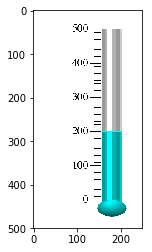

In [5]:
# Sample Images
print("Displaying from Original Dataset")
plt.imshow(x_images[0])

This is what is fed to the CNN


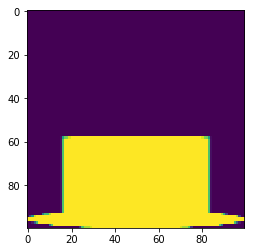

In [6]:
print("This is what is fed to the CNN")
im = x_test[0]
im = im.reshape(im.shape[0], im.shape[1])
plt.imshow(im)

In [7]:
# Convert images into proper format that keras reads
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
# Data Normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
# Label Encoder
le = preprocessing.LabelEncoder()
le.fit(np.unique(y_all))
y_train = le.transform(y_train) 
y_test = le.transform(y_test) 
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

/home/dhingratul/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# Plot Loss in real time 
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.savefig("figs/{}.png".format(epoch))
        plt.show();
        
plot_losses = PlotLosses()

In [11]:
#  Model Definition
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape,
                 padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Model Summary
model.summary()
# Train Model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       295168    
__________

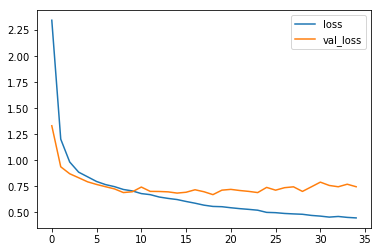

14456/14456 [==============================] - 13s - loss: 0.4456 - acc: 0.8682 - val_loss: 0.7453 - val_acc: 0.8180


In [12]:
# Train Model
train = True  ## Set it to True if you want to train the model again
datagen = False
if train is True:
    if datagen is True:
        datagen = ImageDataGenerator(
                featurewise_center=False,
                zca_whitening=False,
                shear_range=0.,
                rotation_range=0.,
                featurewise_std_normalization=False,
                width_shift_range=0,
                height_shift_range=0,
                horizontal_flip=True)
     
        datagen.fit(x_train)
        model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[plot_losses])
    else:
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_test, y_test)
                  ,callbacks=[plot_losses])
    model.save('model/model.h5')
    # Model Plot
    plot_model(model, to_file='img/model.png')
else:
    model = load_model('model/model.h5')

In [13]:
print(help(getData.metric))

Help on function metric in module getData:

metric(model, x, y, test_cases, le)
    Helper function to get +1/-1 metric which is defined as follows:
    A prediction is assumed correct if the prediction is within the range of 
    [-1, +1] around the ground truth
    example: Prediction of (46, 47, 48) is acceptable in case where ground truth is 47
    
    Input: {model, x, y, test_cases, le}
    -- model = keras model, 
    -- x = X matrix
    -- y = y matrix,
    -- test_cases = Number of samples from 0 index to produce metric on
    -- le = LabelEncoder() object used to transform y matrix
    
    Output: {gnd, pred, acc} 
    -- gnd = Label encoder transformed ground truth labels
    -- pred = Label encoder transformed predicted labels 
    -- acc * 100 = Percent accuracy on metric

None


In [14]:
# Overall Performance on Training Set
_, _, perf = getData.metric(model,x_train, y_train, y_train.shape[0], le)
print(perf)

93.9886552297


In [15]:
# Overall Performance on Testing Set
_, _, perf = getData.metric(model, x_test, y_test, y_test.shape[0], le)
print(perf)

91.3


In [16]:
# Predictions
gnd, pred, _ = getData.metric(model, x_test, y_test, 50, le)
print("Ground truth labels: {} \n Predicted Labels:    {}" .format(gnd[0:10], pred[0:10]))

Ground truth labels: [ 40.  35.  65.  25.  52.  46.  47.  60.  43.  39.] 
 Predicted Labels:    [ 40.  34.  65.  25.  52.  46.  46.  60.  43.  39.]


Exact prediction with GND truth 40.0 and Predicted label 40.0


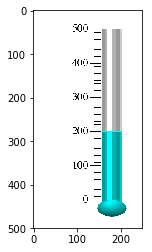

In [17]:
# Visual Inspect outputs -- Exact Prediction
idx =(gnd == pred)
idx = np.argmax(idx)
print("Exact prediction with GND truth {} and Predicted label {}".format(gnd[idx], pred[idx]))
plt.imshow(x_images[idx])

Accruate prediction based on user defined metric with GND truth 35.0 and Predicted label 34.0


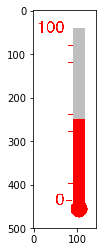

In [18]:
# Visual Inspect outputs -- Correct Prediction based on user defined metric
idx =(pred == gnd + 1) | (pred == gnd - 1)
idx = np.argmax(idx)
print("Accruate prediction based on user defined metric with GND truth {} and Predicted label {}".format(gnd[idx], pred[idx]))
plt.imshow(x_images[6])

Incorrect prediction based on user defined metric with GND truth 40.0 and Predicted label 50.0


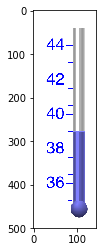

In [19]:
# Visual Inspect outputs -- Incorrect Prediction
mask =(pred == gnd + 1) | (pred == gnd - 1) | (pred == gnd)
mask = np.nonzero(np.invert(mask))
idx = mask[0][0]
print("Incorrect prediction based on user defined metric with GND truth {} and Predicted label {}".format(gnd[idx], pred[idx]))
plt.imshow(x_images[idx])

This is what is fed to the CNN


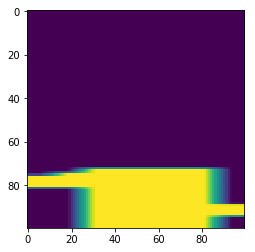

In [20]:
# Failure Case -- Algorithm fails when the pre-processing fails 
print("This is what is fed to the CNN")
im = x_test[idx]
im = im.reshape(im.shape[0], im.shape[1])
plt.imshow(im)

Incorrect prediction based on user defined metric with GND truth 40.0 and Predicted label 54.0


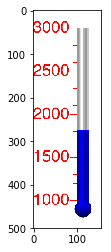

In [21]:
# Visual Inspect outputs -- Incorrect Prediction
mask =(pred == gnd + 1) | (pred == gnd - 1) | (pred == gnd)
mask = np.nonzero(np.invert(mask))
idx = mask[0][1]
print("Incorrect prediction based on user defined metric with GND truth {} and Predicted label {}".format(gnd[idx], pred[idx]))
plt.imshow(x_images[idx])

This is what is fed to the CNN


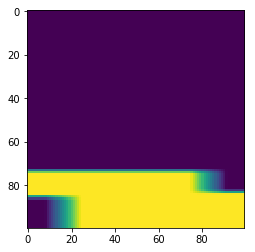

In [22]:
# Failure Case -- Algorithm fails when the pre-processing fails 
print("This is what is fed to the CNN")
im = x_test[idx]
im = im.reshape(im.shape[0], im.shape[1])
plt.imshow(im)